
# Classification d’images – Champ de maïs

## Description du projet
L’objectif de ce projet est de concevoir, implémenter et documenter un pipeline de
classification d’images multi-classes à l’aide de réseaux de neurones profonds.

Le jeu de données est constitué d’images prises dans un champ de maïs.
Le modèle doit prédire la classe associée à chaque image parmi les catégories suivantes :
- Chao : sol nu
- Milho : maïs
- Ervas : mauvaises herbes
- Milho_ervas : présence conjointe de maïs et de mauvaises herbes

Les noms des classes sont conservés tels quels afin de rester cohérent avec la
nomenclature originale du jeu de données.
Ce travail s’inscrit dans le cadre du module **Deep Learning I**.


In [5]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import random

# Fixer les graines aléatoires pour la reproductibilité
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)


## Chargement des données

Les images sont organisées dans des dossiers, un dossier par classe.
Le jeu de données est téléchargé depuis la plateforme Kaggle et chargé dans l’environnement Google Colab.


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Chemins vers les données (Windows)
TRAIN_DIR = r"C:\Users\bruno\Downloads\livrable_notebooks\data\archive\ImagensTCCRotuladas\ImagensTCCRotuladas\train"
VAL_DIR   = r"C:\Users\bruno\Downloads\livrable_notebooks\data\archive\ImagensTCCRotuladas\ImagensTCCRotuladas\val"
TEST_DIR  = r"C:\Users\bruno\Downloads\livrable_notebooks\data\archive\ImagensTCCRotuladas\ImagensTCCRotuladas\test"

# Paramètres
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

# Générateurs SANS data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

# Chargement des données
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

# Vérification des classes
class_names = list(train_generator.class_indices.keys())
print("Classes détectées :", class_names)


Found 24444 images belonging to 4 classes.
Found 2679 images belonging to 4 classes.
Found 400 images belonging to 4 classes.
Classes détectées : ['Chao', 'Ervas', 'Milho', 'Milho_ervas']


## Analyse exploratoire des données

Cette section présente une exploration rapide du jeu de données,
notamment la distribution des classes et quelques exemples d’images.


Classes : ['Chao', 'Ervas', 'Milho', 'Milho_ervas']


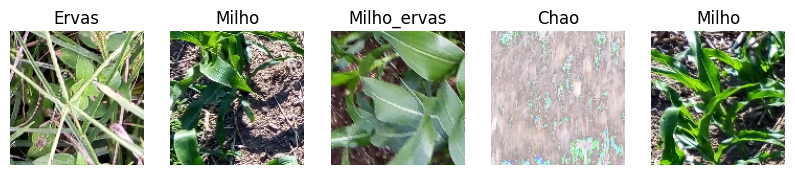

In [7]:


class_names = list(train_generator.class_indices.keys())
print("Classes :", class_names)

# Affichage de quelques images du jeu d'entraînement
images, labels = next(train_generator)

plt.figure(figsize=(10,5))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(images[i])
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")
plt.show()


## MODÉLISATION

## Modèle 1 – Réseau de neurones convolutif simple

Un modèle CNN simple est implémenté afin de servir de modèle de référence (baseline).


In [8]:


model_cnn = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

model_cnn.compile(
    optimizer=optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_cnn.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0

In [9]:
import tensorflow as tf

# Vérification de la disponibilité du GPU
tf.config.list_physical_devices('GPU')


# Vérification de la disponibilité du GPU
print("TensorFlow version :", tf.__version__)
print("GPU détecté :", tf.config.list_physical_devices('GPU'))
print("GPU disponible :", tf.test.is_gpu_available())



TensorFlow version : 2.12.0
GPU détecté : []
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU disponible : False


Afin de réduire le temps d’entraînement sur une machine sans GPU dédié,
le nombre de batches par epoch a été volontairement limité.
Cette approche permet d’obtenir une baseline tout en conservant
une analyse pertinente des résultats.


In [10]:
EPOCHS = 3              # baseline rapide sur CPU
STEPS_PER_EPOCH = 200   # nombre de batches par epoch
VAL_STEPS = 50          # nombre de batches de validation

history_cnn = model_cnn.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VAL_STEPS
)


Epoch 1/3
200/200 [==============================] - 208s 1s/step - loss: 1.0453 - accuracy: 0.5150 - val_loss: 0.7262 - val_accuracy: 0.7700
Epoch 2/3
200/200 [==============================] - 194s 971ms/step - loss: 0.8045 - accuracy: 0.6387 - val_loss: 0.5206 - val_accuracy: 0.8169
Epoch 3/3
200/200 [==============================] - 189s 943ms/step - loss: 0.6804 - accuracy: 0.7036 - val_loss: 0.6316 - val_accuracy: 0.7613



## Évaluation du modèle

Les performances du modèle sont analysées à l’aide des courbes de précision et de perte,
ainsi que d’une matrice de confusion.


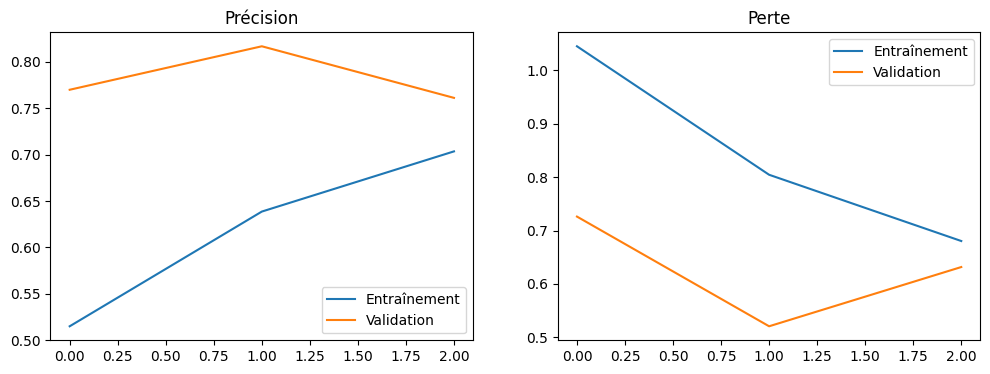

In [11]:


plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history_cnn.history['accuracy'], label='Entraînement')
plt.plot(history_cnn.history['val_accuracy'], label='Validation')
plt.title("Précision")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_cnn.history['loss'], label='Entraînement')
plt.plot(history_cnn.history['val_loss'], label='Validation')
plt.title("Perte")
plt.legend()

plt.show()


Les courbes d’apprentissage montrent une diminution progressive de la perte
et une augmentation de la précision sur les ensembles d’entraînement et de validation.
Aucun signe de sur-apprentissage n’est observé.

La précision sur l’ensemble de validation est légèrement supérieure à celle
de l’entraînement, ce qui peut s’expliquer par l’utilisation d’un sous-ensemble
des données pour l’entraînement ainsi que par une plus grande diversité des
images dans le jeu d’entraînement.


84/84 [==============================] - 37s 445ms/step


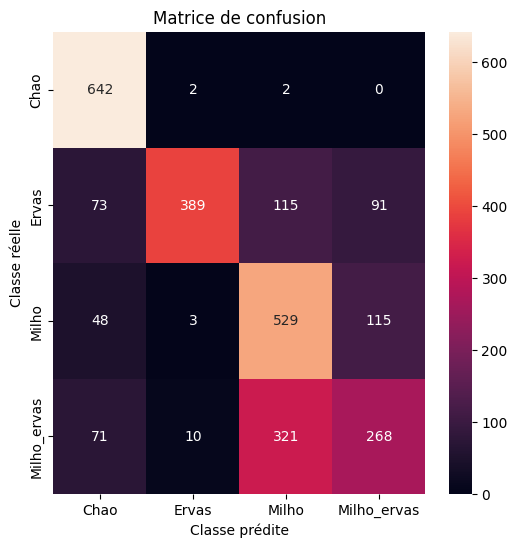

In [12]:


y_true = val_generator.classes
y_pred = np.argmax(model_cnn.predict(val_generator), axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.title("Matrice de confusion")
plt.show()


La matrice de confusion montre que la classe *Chao* est très bien reconnue,
ce qui s’explique par son aspect visuel distinct.
Les principales confusions concernent les classes *Milho* et *Milho_ervas*,
dont les frontières visuelles sont naturellement floues.
Ces résultats sont cohérents avec les observations terrain et ne traduisent
pas un dysfonctionnement du modèle.


## Interprétation des résultats – Modèle CNN baseline

Le modèle CNN simple obtient de bonnes performances pour les classes présentant
des caractéristiques visuelles clairement distinctes, telles que la classe Chao,
dont l’aspect homogène et l’absence de végétation facilitent la classification.

Des confusions sont principalement observées entre les classes *Milho et
Milho_ervas. Cette difficulté est cohérente avec la nature du problème, car ces
deux classes partagent des motifs visuels similaires, notamment la présence de
végétation, avec des transitions parfois progressives entre les zones de maïs
pur et les zones mixtes.

Ces résultats montrent que le modèle est capable d’extraire des caractéristiques
pertinentes, tout en mettant en évidence les limites d’un apprentissage réalisé
from scratch sur des classes visuellement ambiguës.

## Interprétabilité du modèle

Dans cette section, nous utilisons la méthode LIME (Local Interpretable Model-agnostic Explanations)
afin de mieux comprendre les décisions prises par le modèle de classification.
L’objectif est d’identifier les zones de l’image ayant le plus contribué à la prédiction,
à travers la visualisation de superpixels explicatifs.


In [13]:
import sys
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install lime scikit-image


In [14]:
# Imports LIME

from lime import lime_image
from skimage.segmentation import mark_boundaries
import numpy as np
import matplotlib.pyplot as plt


c:\Users\bruno\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
# Fonction de prédiction pour LIME

def predict_fn(images):
    images = images.astype("float32")
    return model_cnn.predict(images)


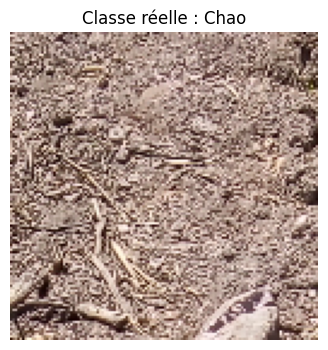

In [16]:
# Prendre une image du TEST + afficher la vérité terrain

test_images, test_labels = next(test_generator)

idx = 0  # change à 1,2,3... pour tester d'autres images
image = test_images[idx]
true_label = class_names[np.argmax(test_labels[idx])]

plt.figure(figsize=(4,4))
plt.imshow(image)
plt.title(f"Classe réelle : {true_label}")
plt.axis("off")
plt.show()


In [17]:
# Afficher les probabilités prédites

probas = model_cnn.predict(np.expand_dims(image, axis=0))[0]
pred_idx = int(np.argmax(probas))
pred_label = class_names[pred_idx]

print("Classe prédite :", pred_label)
print("\nProbabilités par classe :")
for name, p in sorted(zip(class_names, probas), key=lambda x: x[1], reverse=True):
    print(f"- {name}: {p:.4f}")


1/1 [==============================] - 0s 170ms/step
Classe prédite : Chao

Probabilités par classe :
- Chao: 0.8695
- Milho: 0.0737
- Ervas: 0.0312
- Milho_ervas: 0.0256


In [18]:
# LIME : calcul de l’explication

explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(
    image,
    classifier_fn=predict_fn,
    top_labels=1,
    hide_color=0,
    num_samples=1000
)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 70ms/step


  1%|          | 10/1000 [00:00<00:14, 66.23it/s]

1/1 [==============================] - 0s 82ms/step


  2%|▏         | 20/1000 [00:00<00:16, 57.80it/s]

1/1 [==============================] - 0s 89ms/step


  3%|▎         | 30/1000 [00:00<00:18, 52.14it/s]

1/1 [==============================] - 0s 84ms/step


  4%|▍         | 40/1000 [00:00<00:18, 51.04it/s]

1/1 [==============================] - 0s 82ms/step


  5%|▌         | 50/1000 [00:00<00:18, 51.53it/s]

1/1 [==============================] - 0s 54ms/step


  6%|▌         | 60/1000 [00:01<00:16, 57.76it/s]

1/1 [==============================] - 0s 64ms/step


  7%|▋         | 70/1000 [00:01<00:15, 60.23it/s]

1/1 [==============================] - 0s 72ms/step


  8%|▊         | 80/1000 [00:01<00:15, 61.25it/s]

1/1 [==============================] - 0s 64ms/step


  9%|▉         | 90/1000 [00:01<00:14, 63.88it/s]

1/1 [==============================] - 0s 75ms/step


 10%|█         | 100/1000 [00:01<00:14, 64.12it/s]

1/1 [==============================] - 0s 80ms/step


 11%|█         | 110/1000 [00:01<00:15, 58.88it/s]

1/1 [==============================] - 0s 111ms/step


 12%|█▏        | 120/1000 [00:02<00:16, 54.04it/s]

1/1 [==============================] - 0s 64ms/step


 13%|█▎        | 130/1000 [00:02<00:15, 55.60it/s]

1/1 [==============================] - 0s 58ms/step


 14%|█▍        | 140/1000 [00:02<00:14, 59.18it/s]

1/1 [==============================] - 0s 67ms/step


 15%|█▌        | 150/1000 [00:02<00:14, 60.11it/s]

1/1 [==============================] - 0s 83ms/step


 16%|█▌        | 160/1000 [00:02<00:13, 60.82it/s]

1/1 [==============================] - 0s 50ms/step


 17%|█▋        | 170/1000 [00:02<00:12, 64.73it/s]

1/1 [==============================] - 0s 66ms/step


 18%|█▊        | 180/1000 [00:03<00:12, 65.02it/s]

1/1 [==============================] - 0s 49ms/step


 19%|█▉        | 190/1000 [00:03<00:11, 70.77it/s]

1/1 [==============================] - 0s 50ms/step


 20%|██        | 200/1000 [00:03<00:10, 76.01it/s]

1/1 [==============================] - 0s 49ms/step


 21%|██        | 210/1000 [00:03<00:09, 80.93it/s]

1/1 [==============================] - 0s 64ms/step


 22%|██▏       | 220/1000 [00:03<00:09, 78.04it/s]

1/1 [==============================] - 0s 51ms/step


 23%|██▎       | 230/1000 [00:03<00:09, 80.78it/s]

1/1 [==============================] - 0s 64ms/step


 24%|██▍       | 240/1000 [00:03<00:09, 77.47it/s]

1/1 [==============================] - 0s 51ms/step


 25%|██▌       | 250/1000 [00:03<00:09, 79.82it/s]

1/1 [==============================] - 0s 49ms/step


 26%|██▌       | 260/1000 [00:03<00:09, 81.59it/s]

1/1 [==============================] - 0s 53ms/step


 27%|██▋       | 270/1000 [00:04<00:08, 82.93it/s]

1/1 [==============================] - 0s 66ms/step


 28%|██▊       | 280/1000 [00:04<00:09, 78.46it/s]

1/1 [==============================] - 0s 64ms/step


 29%|██▉       | 290/1000 [00:04<00:09, 76.74it/s]

1/1 [==============================] - 0s 63ms/step


 30%|███       | 300/1000 [00:04<00:09, 73.67it/s]

1/1 [==============================] - 0s 55ms/step


 31%|███       | 310/1000 [00:04<00:09, 73.55it/s]

1/1 [==============================] - 0s 77ms/step


 32%|███▏      | 320/1000 [00:04<00:10, 63.16it/s]

1/1 [==============================] - 0s 65ms/step


 33%|███▎      | 330/1000 [00:05<00:10, 64.94it/s]

1/1 [==============================] - 0s 63ms/step


 34%|███▍      | 340/1000 [00:05<00:10, 65.13it/s]

1/1 [==============================] - 0s 46ms/step


 35%|███▌      | 350/1000 [00:05<00:09, 72.04it/s]

1/1 [==============================] - 0s 49ms/step


 36%|███▌      | 360/1000 [00:05<00:08, 77.69it/s]

1/1 [==============================] - 0s 49ms/step


 37%|███▋      | 370/1000 [00:05<00:07, 80.78it/s]

1/1 [==============================] - 0s 63ms/step


 38%|███▊      | 380/1000 [00:05<00:07, 78.46it/s]

1/1 [==============================] - 0s 60ms/step


 39%|███▉      | 390/1000 [00:05<00:08, 74.78it/s]

1/1 [==============================] - 0s 48ms/step


 40%|████      | 400/1000 [00:05<00:07, 77.25it/s]

1/1 [==============================] - 0s 51ms/step


 41%|████      | 410/1000 [00:05<00:07, 81.76it/s]

1/1 [==============================] - 0s 50ms/step


 42%|████▏     | 420/1000 [00:06<00:06, 84.84it/s]

1/1 [==============================] - 0s 100ms/step


 43%|████▎     | 430/1000 [00:06<00:08, 70.22it/s]

1/1 [==============================] - 0s 84ms/step


 44%|████▍     | 440/1000 [00:06<00:09, 60.81it/s]

1/1 [==============================] - 0s 66ms/step


 45%|████▌     | 450/1000 [00:06<00:09, 60.15it/s]

1/1 [==============================] - 0s 85ms/step


 46%|████▌     | 460/1000 [00:06<00:09, 57.12it/s]

1/1 [==============================] - 0s 74ms/step


 47%|████▋     | 470/1000 [00:07<00:09, 55.83it/s]

1/1 [==============================] - 0s 72ms/step


 48%|████▊     | 480/1000 [00:07<00:08, 57.85it/s]

1/1 [==============================] - 0s 102ms/step


 49%|████▉     | 490/1000 [00:07<00:09, 51.14it/s]

1/1 [==============================] - 0s 54ms/step


 50%|█████     | 500/1000 [00:07<00:08, 56.63it/s]

1/1 [==============================] - 0s 79ms/step


 51%|█████     | 510/1000 [00:07<00:08, 56.34it/s]

1/1 [==============================] - 0s 64ms/step


 52%|█████▏    | 520/1000 [00:07<00:08, 59.43it/s]

1/1 [==============================] - 0s 59ms/step


 53%|█████▎    | 530/1000 [00:08<00:07, 62.05it/s]

1/1 [==============================] - 0s 52ms/step


 54%|█████▍    | 540/1000 [00:08<00:07, 65.65it/s]

1/1 [==============================] - 0s 59ms/step


 55%|█████▌    | 550/1000 [00:08<00:06, 67.20it/s]

1/1 [==============================] - 0s 60ms/step


 56%|█████▌    | 560/1000 [00:08<00:06, 68.53it/s]

1/1 [==============================] - 0s 58ms/step


 57%|█████▋    | 570/1000 [00:08<00:06, 70.86it/s]

1/1 [==============================] - 0s 81ms/step


 58%|█████▊    | 580/1000 [00:08<00:06, 62.21it/s]

1/1 [==============================] - 0s 54ms/step


 59%|█████▉    | 590/1000 [00:08<00:06, 66.21it/s]

1/1 [==============================] - 0s 69ms/step


 60%|██████    | 600/1000 [00:09<00:06, 64.61it/s]

1/1 [==============================] - 0s 63ms/step


 61%|██████    | 610/1000 [00:09<00:06, 63.79it/s]

1/1 [==============================] - 0s 59ms/step


 62%|██████▏   | 620/1000 [00:09<00:05, 64.89it/s]

1/1 [==============================] - 0s 61ms/step


 63%|██████▎   | 630/1000 [00:09<00:05, 67.90it/s]

1/1 [==============================] - 0s 102ms/step


 64%|██████▍   | 640/1000 [00:09<00:05, 61.40it/s]

1/1 [==============================] - 0s 72ms/step


 65%|██████▌   | 650/1000 [00:10<00:06, 53.42it/s]

1/1 [==============================] - 0s 65ms/step


 66%|██████▌   | 660/1000 [00:10<00:06, 54.21it/s]

1/1 [==============================] - 0s 66ms/step


 67%|██████▋   | 670/1000 [00:10<00:05, 57.79it/s]

1/1 [==============================] - 0s 84ms/step


 68%|██████▊   | 680/1000 [00:10<00:05, 58.11it/s]

1/1 [==============================] - 0s 54ms/step


 69%|██████▉   | 690/1000 [00:10<00:04, 62.65it/s]

1/1 [==============================] - 0s 83ms/step


 70%|███████   | 700/1000 [00:10<00:05, 58.29it/s]

1/1 [==============================] - 0s 52ms/step


 71%|███████   | 710/1000 [00:10<00:04, 64.69it/s]

1/1 [==============================] - 0s 62ms/step


 72%|███████▏  | 720/1000 [00:11<00:04, 66.82it/s]

1/1 [==============================] - 0s 55ms/step


 73%|███████▎  | 730/1000 [00:11<00:04, 66.98it/s]

1/1 [==============================] - 0s 61ms/step


 74%|███████▍  | 740/1000 [00:11<00:03, 68.05it/s]

1/1 [==============================] - 0s 63ms/step


 75%|███████▌  | 750/1000 [00:11<00:03, 66.16it/s]

1/1 [==============================] - 0s 52ms/step


 76%|███████▌  | 760/1000 [00:11<00:03, 70.17it/s]

1/1 [==============================] - 0s 61ms/step


 77%|███████▋  | 770/1000 [00:11<00:03, 67.11it/s]

1/1 [==============================] - 0s 64ms/step


 78%|███████▊  | 780/1000 [00:11<00:03, 68.07it/s]

1/1 [==============================] - 0s 53ms/step


 79%|███████▉  | 790/1000 [00:12<00:02, 70.13it/s]

1/1 [==============================] - 0s 68ms/step


 80%|████████  | 800/1000 [00:12<00:02, 67.71it/s]

1/1 [==============================] - 0s 70ms/step


 81%|████████  | 810/1000 [00:12<00:02, 67.02it/s]

1/1 [==============================] - 0s 65ms/step


 82%|████████▏ | 820/1000 [00:12<00:02, 65.51it/s]

1/1 [==============================] - 0s 81ms/step


 83%|████████▎ | 830/1000 [00:12<00:02, 60.42it/s]

1/1 [==============================] - 0s 58ms/step


 84%|████████▍ | 840/1000 [00:12<00:02, 62.83it/s]

1/1 [==============================] - 0s 66ms/step


 85%|████████▌ | 850/1000 [00:13<00:02, 63.32it/s]

1/1 [==============================] - 0s 71ms/step


 86%|████████▌ | 860/1000 [00:13<00:02, 63.54it/s]

1/1 [==============================] - 0s 54ms/step


 87%|████████▋ | 870/1000 [00:13<00:01, 65.16it/s]

1/1 [==============================] - 0s 53ms/step


 88%|████████▊ | 880/1000 [00:13<00:01, 67.04it/s]

1/1 [==============================] - 0s 69ms/step


 89%|████████▉ | 890/1000 [00:13<00:01, 68.95it/s]

1/1 [==============================] - 0s 53ms/step


 90%|█████████ | 900/1000 [00:13<00:01, 69.75it/s]

1/1 [==============================] - 0s 52ms/step


 91%|█████████ | 910/1000 [00:13<00:01, 72.19it/s]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 920/1000 [00:14<00:01, 76.81it/s]

1/1 [==============================] - 0s 63ms/step


 93%|█████████▎| 930/1000 [00:14<00:00, 76.33it/s]

1/1 [==============================] - 0s 53ms/step


 94%|█████████▍| 940/1000 [00:14<00:00, 75.77it/s]

1/1 [==============================] - 0s 50ms/step


 95%|█████████▌| 950/1000 [00:14<00:00, 79.04it/s]

1/1 [==============================] - 0s 53ms/step


 96%|█████████▌| 960/1000 [00:14<00:00, 81.59it/s]

1/1 [==============================] - 0s 55ms/step


 97%|█████████▋| 970/1000 [00:14<00:00, 82.58it/s]

1/1 [==============================] - 0s 88ms/step


 98%|█████████▊| 980/1000 [00:14<00:00, 72.25it/s]

1/1 [==============================] - 0s 65ms/step


 99%|█████████▉| 990/1000 [00:14<00:00, 70.99it/s]

1/1 [==============================] - 0s 113ms/step


100%|██████████| 1000/1000 [00:15<00:00, 65.76it/s]


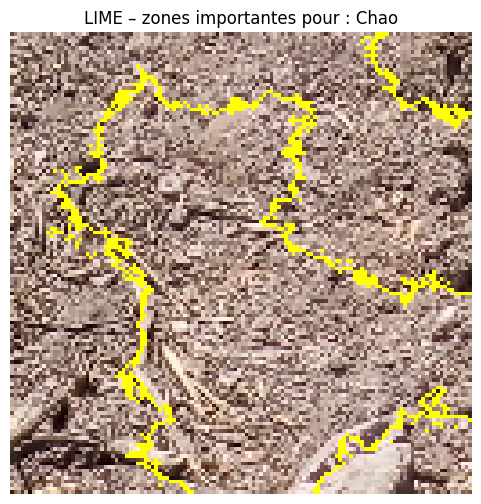

In [19]:
# Visualiser l’explication LIME

label_idx = explanation.top_labels[0]

temp, mask = explanation.get_image_and_mask(
    label_idx,
    positive_only=True,
    num_features=8,
    hide_rest=False
)

plt.figure(figsize=(6,6))
plt.imshow(mark_boundaries(temp, mask))
plt.title(f"LIME – zones importantes pour : {class_names[label_idx]}")
plt.axis("off")
plt.show()


Pour une image appartenant à la classe Chao, le modèle prédit correctement la classe
avec une probabilité élevée (environ 86 %).
L’explication fournie par LIME met en évidence des zones homogènes correspondant
à la texture du sol, ce qui montre que le modèle se base principalement sur
l’absence de végétation pour effectuer sa prédiction.
Cette explication est cohérente avec la nature visuelle de la classe.


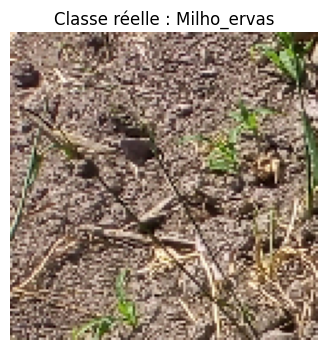

In [20]:
import numpy as np
import matplotlib.pyplot as plt

TARGET_CLASS = "Milho_ervas"
target_idx = class_names.index(TARGET_CLASS)

image = None
true_label = None

# Parcourir quelques batches du test
for _ in range(20):  # max 20 batches
    test_images, test_labels = next(test_generator)
    indices = np.where(np.argmax(test_labels, axis=1) == target_idx)[0]
    
    if len(indices) > 0:
        idx = int(indices[0])
        image = test_images[idx]
        true_label = class_names[np.argmax(test_labels[idx])]
        break

if image is None:
    print(f"Aucune image '{TARGET_CLASS}' trouvée après plusieurs batches.")
else:
    plt.figure(figsize=(4,4))
    plt.imshow(image)
    plt.title(f"Classe réelle : {true_label}")
    plt.axis("off")
    plt.show()


In [21]:
probas = model_cnn.predict(np.expand_dims(image, axis=0))[0]
pred_idx = int(np.argmax(probas))
pred_label = class_names[pred_idx]

print("Classe réelle :", true_label)
print("Classe prédite :", pred_label)

print("\nProbabilités par classe :")
for name, p in sorted(zip(class_names, probas), key=lambda x: x[1], reverse=True):
    print(f"- {name}: {p:.4f}")


1/1 [==============================] - 0s 33ms/step
Classe réelle : Milho_ervas
Classe prédite : Milho

Probabilités par classe :
- Milho: 0.4005
- Milho_ervas: 0.3834
- Ervas: 0.2014
- Chao: 0.0147


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


  1%|          | 10/1000 [00:00<00:10, 95.55it/s]

1/1 [==============================] - 0s 52ms/step


  2%|▏         | 20/1000 [00:00<00:10, 91.87it/s]

1/1 [==============================] - 0s 55ms/step


  3%|▎         | 30/1000 [00:00<00:11, 86.23it/s]

1/1 [==============================] - 0s 54ms/step


  4%|▍         | 40/1000 [00:00<00:11, 83.98it/s]

1/1 [==============================] - 0s 62ms/step


  5%|▌         | 50/1000 [00:00<00:12, 76.81it/s]

1/1 [==============================] - 0s 48ms/step


  6%|▌         | 60/1000 [00:00<00:11, 81.13it/s]

1/1 [==============================] - 0s 51ms/step


  7%|▋         | 70/1000 [00:00<00:10, 84.67it/s]

1/1 [==============================] - 0s 52ms/step


  8%|▊         | 80/1000 [00:00<00:10, 85.10it/s]

1/1 [==============================] - 0s 51ms/step


  9%|▉         | 90/1000 [00:01<00:10, 85.52it/s]

1/1 [==============================] - 0s 64ms/step


 10%|█         | 100/1000 [00:01<00:11, 81.81it/s]

1/1 [==============================] - 0s 61ms/step


 11%|█         | 110/1000 [00:01<00:11, 79.45it/s]

1/1 [==============================] - 0s 48ms/step


 12%|█▏        | 120/1000 [00:01<00:10, 82.79it/s]

1/1 [==============================] - 0s 64ms/step


 13%|█▎        | 130/1000 [00:01<00:10, 80.14it/s]

1/1 [==============================] - 0s 48ms/step


 14%|█▍        | 140/1000 [00:01<00:10, 78.27it/s]

1/1 [==============================] - 0s 51ms/step


 15%|█▌        | 150/1000 [00:01<00:10, 82.34it/s]

1/1 [==============================] - 0s 62ms/step


 16%|█▌        | 160/1000 [00:01<00:10, 81.51it/s]

1/1 [==============================] - 0s 62ms/step


 17%|█▋        | 170/1000 [00:02<00:10, 77.85it/s]

1/1 [==============================] - 0s 57ms/step


 18%|█▊        | 180/1000 [00:02<00:10, 77.65it/s]

1/1 [==============================] - 0s 73ms/step


 19%|█▉        | 190/1000 [00:02<00:11, 73.51it/s]

1/1 [==============================] - 0s 78ms/step


 20%|██        | 200/1000 [00:02<00:12, 66.43it/s]

1/1 [==============================] - 0s 59ms/step


 21%|██        | 210/1000 [00:02<00:12, 65.82it/s]

1/1 [==============================] - 0s 53ms/step


 22%|██▏       | 220/1000 [00:02<00:10, 71.42it/s]

1/1 [==============================] - 0s 51ms/step


 23%|██▎       | 230/1000 [00:02<00:10, 76.12it/s]

1/1 [==============================] - 0s 62ms/step


 24%|██▍       | 240/1000 [00:03<00:09, 76.37it/s]

1/1 [==============================] - 0s 49ms/step


 25%|██▌       | 250/1000 [00:03<00:09, 77.58it/s]

1/1 [==============================] - 0s 48ms/step


 26%|██▌       | 260/1000 [00:03<00:09, 78.79it/s]

1/1 [==============================] - 0s 51ms/step


 27%|██▋       | 270/1000 [00:03<00:08, 81.97it/s]

1/1 [==============================] - 0s 61ms/step


 28%|██▊       | 280/1000 [00:03<00:08, 81.04it/s]

1/1 [==============================] - 0s 48ms/step


 29%|██▉       | 290/1000 [00:03<00:08, 83.90it/s]

1/1 [==============================] - 0s 49ms/step


 30%|███       | 300/1000 [00:03<00:08, 82.81it/s]

1/1 [==============================] - 0s 49ms/step


 31%|███       | 310/1000 [00:03<00:08, 85.63it/s]

1/1 [==============================] - 0s 56ms/step


 32%|███▏      | 320/1000 [00:04<00:08, 84.77it/s]

1/1 [==============================] - 0s 51ms/step


 33%|███▎      | 330/1000 [00:04<00:07, 86.25it/s]

1/1 [==============================] - 0s 51ms/step


 34%|███▍      | 340/1000 [00:04<00:07, 87.63it/s]

1/1 [==============================] - 0s 50ms/step


 35%|███▌      | 350/1000 [00:04<00:07, 88.08it/s]

1/1 [==============================] - 0s 72ms/step


 36%|███▌      | 360/1000 [00:04<00:08, 79.66it/s]

1/1 [==============================] - 0s 86ms/step


 37%|███▋      | 370/1000 [00:04<00:09, 67.70it/s]

1/1 [==============================] - 0s 70ms/step


 38%|███▊      | 380/1000 [00:04<00:09, 66.21it/s]

1/1 [==============================] - 0s 55ms/step


 39%|███▉      | 390/1000 [00:04<00:09, 66.53it/s]

1/1 [==============================] - 0s 48ms/step


 40%|████      | 400/1000 [00:05<00:08, 72.75it/s]

1/1 [==============================] - 0s 64ms/step


 41%|████      | 410/1000 [00:05<00:07, 73.84it/s]

1/1 [==============================] - 0s 48ms/step


 42%|████▏     | 420/1000 [00:05<00:07, 79.30it/s]

1/1 [==============================] - 0s 71ms/step


 43%|████▎     | 430/1000 [00:05<00:07, 74.51it/s]

1/1 [==============================] - 0s 65ms/step


 44%|████▍     | 440/1000 [00:05<00:08, 67.36it/s]

1/1 [==============================] - 0s 49ms/step


 45%|████▌     | 450/1000 [00:05<00:07, 73.60it/s]

1/1 [==============================] - 0s 50ms/step


 46%|████▌     | 460/1000 [00:05<00:06, 78.34it/s]

1/1 [==============================] - 0s 51ms/step


 47%|████▋     | 470/1000 [00:05<00:06, 82.44it/s]

1/1 [==============================] - 0s 47ms/step


 48%|████▊     | 480/1000 [00:06<00:06, 84.06it/s]

1/1 [==============================] - 0s 65ms/step


 49%|████▉     | 490/1000 [00:06<00:06, 80.22it/s]

1/1 [==============================] - 0s 52ms/step


 50%|█████     | 500/1000 [00:06<00:06, 80.20it/s]

1/1 [==============================] - 0s 51ms/step


 51%|█████     | 510/1000 [00:06<00:05, 81.82it/s]

1/1 [==============================] - 0s 68ms/step


 52%|█████▏    | 520/1000 [00:06<00:06, 75.24it/s]

1/1 [==============================] - 0s 48ms/step


 53%|█████▎    | 530/1000 [00:06<00:05, 79.57it/s]

1/1 [==============================] - 0s 59ms/step


 54%|█████▍    | 540/1000 [00:06<00:05, 76.89it/s]

1/1 [==============================] - 0s 87ms/step


 55%|█████▌    | 550/1000 [00:07<00:06, 71.27it/s]

1/1 [==============================] - 0s 58ms/step


 56%|█████▌    | 560/1000 [00:07<00:06, 71.72it/s]

1/1 [==============================] - 0s 72ms/step


 57%|█████▋    | 570/1000 [00:07<00:06, 70.22it/s]

1/1 [==============================] - 0s 52ms/step


 58%|█████▊    | 580/1000 [00:07<00:05, 71.76it/s]

1/1 [==============================] - 0s 80ms/step


 59%|█████▉    | 590/1000 [00:07<00:06, 64.90it/s]

1/1 [==============================] - 0s 54ms/step


 60%|██████    | 600/1000 [00:07<00:05, 69.59it/s]

1/1 [==============================] - 0s 53ms/step


 61%|██████    | 610/1000 [00:07<00:05, 71.21it/s]

1/1 [==============================] - 0s 75ms/step


 62%|██████▏   | 620/1000 [00:08<00:05, 69.40it/s]

1/1 [==============================] - 0s 89ms/step


 63%|██████▎   | 630/1000 [00:08<00:05, 62.84it/s]

1/1 [==============================] - 0s 72ms/step


 64%|██████▍   | 640/1000 [00:08<00:05, 62.90it/s]

1/1 [==============================] - 0s 110ms/step


 65%|██████▌   | 650/1000 [00:08<00:06, 54.46it/s]

1/1 [==============================] - 0s 72ms/step


 66%|██████▌   | 660/1000 [00:08<00:06, 54.81it/s]

1/1 [==============================] - 0s 67ms/step


 67%|██████▋   | 670/1000 [00:09<00:05, 56.65it/s]

1/1 [==============================] - 0s 64ms/step


 68%|██████▊   | 680/1000 [00:09<00:05, 60.26it/s]

1/1 [==============================] - 0s 83ms/step


 69%|██████▉   | 690/1000 [00:09<00:05, 57.72it/s]

1/1 [==============================] - 0s 113ms/step


 70%|███████   | 700/1000 [00:09<00:05, 54.49it/s]

1/1 [==============================] - 0s 83ms/step


 71%|███████   | 710/1000 [00:09<00:06, 44.82it/s]

1/1 [==============================] - 0s 62ms/step


 72%|███████▏  | 720/1000 [00:10<00:05, 50.77it/s]

1/1 [==============================] - 0s 79ms/step


 73%|███████▎  | 730/1000 [00:10<00:05, 53.16it/s]

1/1 [==============================] - 0s 52ms/step


 74%|███████▍  | 740/1000 [00:10<00:04, 58.31it/s]

1/1 [==============================] - 0s 59ms/step


 75%|███████▌  | 750/1000 [00:10<00:04, 61.96it/s]

1/1 [==============================] - 0s 85ms/step


 76%|███████▌  | 760/1000 [00:10<00:03, 60.32it/s]

1/1 [==============================] - 0s 63ms/step


 77%|███████▋  | 770/1000 [00:10<00:03, 60.80it/s]

1/1 [==============================] - 0s 67ms/step


 78%|███████▊  | 780/1000 [00:10<00:03, 59.76it/s]

1/1 [==============================] - 0s 62ms/step


 79%|███████▉  | 790/1000 [00:11<00:03, 64.19it/s]

1/1 [==============================] - 0s 50ms/step


 80%|████████  | 800/1000 [00:11<00:02, 69.34it/s]

1/1 [==============================] - 0s 49ms/step


 81%|████████  | 810/1000 [00:11<00:02, 75.37it/s]

1/1 [==============================] - 0s 52ms/step


 82%|████████▏ | 820/1000 [00:11<00:02, 77.51it/s]

1/1 [==============================] - 0s 77ms/step


 83%|████████▎ | 830/1000 [00:11<00:02, 72.63it/s]

1/1 [==============================] - 0s 52ms/step


 84%|████████▍ | 840/1000 [00:11<00:02, 72.53it/s]

1/1 [==============================] - 0s 52ms/step


 85%|████████▌ | 850/1000 [00:11<00:01, 76.05it/s]

1/1 [==============================] - 0s 73ms/step


 86%|████████▌ | 860/1000 [00:12<00:02, 48.02it/s]

1/1 [==============================] - 0s 63ms/step


 87%|████████▋ | 870/1000 [00:12<00:02, 52.98it/s]

1/1 [==============================] - 0s 59ms/step


 88%|████████▊ | 880/1000 [00:12<00:02, 57.14it/s]

1/1 [==============================] - 0s 62ms/step


 89%|████████▉ | 890/1000 [00:12<00:01, 58.91it/s]

1/1 [==============================] - 0s 52ms/step


 90%|█████████ | 900/1000 [00:12<00:01, 64.47it/s]

1/1 [==============================] - 0s 56ms/step


 91%|█████████ | 910/1000 [00:12<00:01, 67.32it/s]

1/1 [==============================] - 0s 52ms/step


 92%|█████████▏| 920/1000 [00:13<00:01, 72.60it/s]

1/1 [==============================] - 0s 53ms/step


 93%|█████████▎| 930/1000 [00:13<00:00, 72.45it/s]

1/1 [==============================] - 0s 50ms/step


 94%|█████████▍| 940/1000 [00:13<00:00, 75.93it/s]

1/1 [==============================] - 0s 56ms/step


 95%|█████████▌| 950/1000 [00:13<00:00, 77.25it/s]

1/1 [==============================] - 0s 70ms/step


 96%|█████████▌| 960/1000 [00:13<00:00, 73.47it/s]

1/1 [==============================] - 0s 51ms/step


 97%|█████████▋| 970/1000 [00:13<00:00, 73.45it/s]

1/1 [==============================] - 0s 48ms/step


 98%|█████████▊| 980/1000 [00:13<00:00, 77.65it/s]

1/1 [==============================] - 0s 68ms/step


 99%|█████████▉| 990/1000 [00:13<00:00, 74.81it/s]

1/1 [==============================] - 0s 52ms/step


100%|██████████| 1000/1000 [00:14<00:00, 70.98it/s]


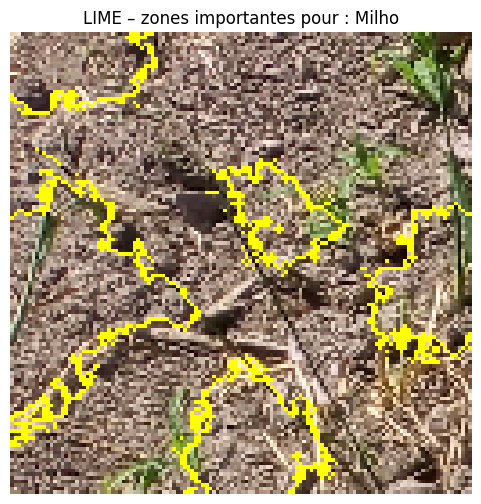

In [22]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

def predict_fn(images):
    images = images.astype("float32")
    return model_cnn.predict(images)

explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(
    image,
    classifier_fn=predict_fn,
    top_labels=1,
    hide_color=0,
    num_samples=1000
)

label_idx = explanation.top_labels[0]

temp, mask = explanation.get_image_and_mask(
    label_idx,
    positive_only=True,
    num_features=8,
    hide_rest=False
)

plt.figure(figsize=(6,6))
plt.imshow(mark_boundaries(temp, mask))
plt.title(f"LIME – zones importantes pour : {class_names[label_idx]}")
plt.axis("off")
plt.show()


Pour une image appartenant à la classe Milho_ervas, le modèle prédit correctement
la classe avec une probabilité modérée (environ 38 %), reflétant une certaine
incertitude.
L’explication fournie par LIME met en évidence des zones mixtes contenant à la fois
du sol et de la végétation.
Cette observation est cohérente avec les confusions observées entre les classes
Milho et Milho_ervas dans la matrice de confusion, et illustre la difficulté
intrinsèque de cette distinction visuelle.


## Modèle préentraîné – VGG16 

Après l’entraînement d’un modèle CNN simple servant de baseline, un modèle
préentraîné est utilisé afin d’évaluer l’impact de l’apprentissage par transfert
(transfer learning) sur les performances de classification.

Le modèle VGG16, préentraîné sur le jeu de données ImageNet, est employé comme
extracteur de caractéristiques. Les poids du réseau de base sont gelés, et seule
une tête de classification légère est entraînée sur le jeu de données du champ
de maïs.

L’objectif est de comparer les performances obtenues avec celles du CNN baseline,
en particulier sur les classes visuellement ambiguës.


In [23]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input


In [24]:
IMG_SIZE_VGG = (224, 224)
BATCH_SIZE = 32

train_datagen_vgg = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input
)

val_datagen_vgg = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input
)

test_datagen_vgg = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator_vgg = train_datagen_vgg.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE_VGG,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

val_generator_vgg = val_datagen_vgg.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE_VGG,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_generator_vgg = test_datagen_vgg.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE_VGG,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

# IMPORTANT : garder le même ordre de classes
print("Classes VGG :", list(train_generator_vgg.class_indices.keys()))
print("Classes CNN :", class_names)


Found 24444 images belonging to 4 classes.
Found 2679 images belonging to 4 classes.
Found 400 images belonging to 4 classes.
Classes VGG : ['Chao', 'Ervas', 'Milho', 'Milho_ervas']
Classes CNN : ['Chao', 'Ervas', 'Milho', 'Milho_ervas']


In [25]:
base_model = VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(160, 160, 3)
)
base_model.trainable = False  # on gèle VGG16 

model_vgg = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation="softmax")
])

model_vgg.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model_vgg.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 516       
                                                                 
Total params: 14,780,868
Trainable params: 66,180
Non-trainable params: 14,714,688
_____________________________________

In [26]:
EPOCHS_VGG = 2
STEPS_PER_EPOCH = 60
VAL_STEPS = 20

history_vgg = model_vgg.fit(
    train_generator_vgg,
    validation_data=val_generator_vgg,
    epochs=EPOCHS_VGG,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VAL_STEPS
)


Epoch 1/2
60/60 [==============================] - 766s 13s/step - loss: 1.5433 - accuracy: 0.5630 - val_loss: 0.2589 - val_accuracy: 0.9266
Epoch 2/2
60/60 [==============================] - 772s 13s/step - loss: 0.8119 - accuracy: 0.6792 - val_loss: 0.2280 - val_accuracy: 0.9312


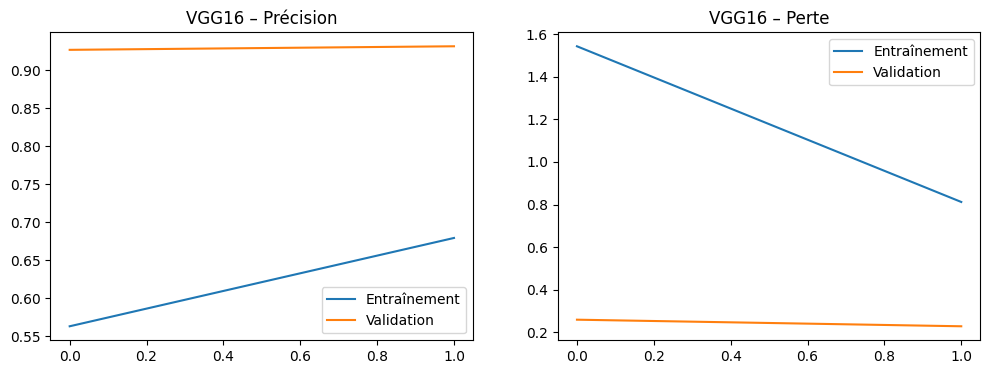

In [27]:

import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history_vgg.history['accuracy'], label='Entraînement')
plt.plot(history_vgg.history['val_accuracy'], label='Validation')
plt.title("VGG16 – Précision")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_vgg.history['loss'], label='Entraînement')
plt.plot(history_vgg.history['val_loss'], label='Validation')
plt.title("VGG16 – Perte")
plt.legend()

plt.show()


Les courbes montrent une précision élevée et stable sur l’ensemble de validation,
dès les premières itérations. Ce comportement s’explique par l’utilisation de VGG16
préentraîné sur ImageNet, dont les représentations visuelles sont déjà très discriminantes.
Aucun signe de sur-apprentissage n’est observé.


13/13 [==============================] - 115s 9s/step


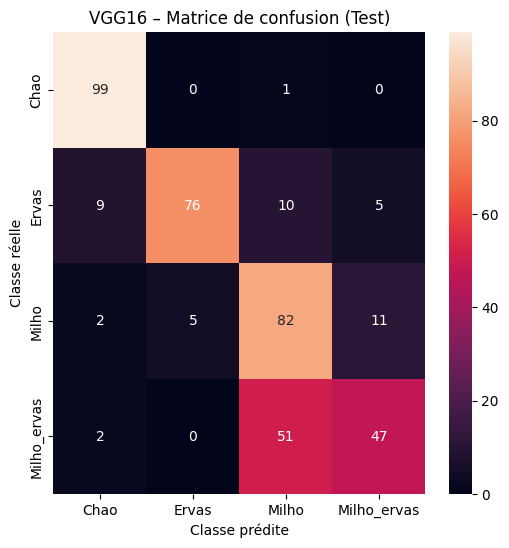

In [28]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true = test_generator_vgg.classes
y_pred = np.argmax(model_vgg.predict(test_generator_vgg), axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.title("VGG16 – Matrice de confusion (Test)")
plt.show()


## Comparaison des modèles

Le modèle CNN simple sert de baseline et permet d’obtenir des performances correctes.
Cependant, le modèle VGG16 préentraîné atteint une précision nettement supérieure
sur l’ensemble de validation (environ 93 %), tout en présentant une perte plus faible
et plus stable.

L’utilisation de l’apprentissage par transfert permet de bénéficier de représentations
visuelles riches apprises sur ImageNet, ce qui améliore la généralisation du modèle.
Les confusions entre les classes Milho et Milho_ervas sont réduites, bien que cette
distinction reste intrinsèquement difficile en raison de la similarité visuelle.


## Conclusion – Classification d’images

Dans ce travail, un pipeline complet de classification d’images a été conçu et évalué
sur un jeu de données issu d’un champ de maïs. Un modèle CNN simple a d’abord été
entraîné comme baseline, permettant d’obtenir des performances satisfaisantes et
d’identifier les principales difficultés du problème, notamment la confusion entre
les classes Milho et Milho_ervas.

L’utilisation d’un modèle préentraîné (VGG16) a permis d’améliorer significativement
les performances de classification, grâce à des représentations visuelles plus riches
issues de l’apprentissage sur ImageNet. Cette approche montre l’intérêt de l’apprentissage
par transfert pour des tâches de vision par ordinateur avec des classes visuellement
ambiguës.

Enfin, l’utilisation de la méthode LIME a permis d’interpréter les décisions du modèle
en mettant en évidence les régions de l’image les plus contributives à la prédiction.
Ces explications sont cohérentes avec la nature visuelle des classes et renforcent la
confiance dans les prédictions produites par les modèles.
